In [1]:
import numpy
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

numpy.set_printoptions(precision=2)

class_names = ['1-EW','2-EA','4-RRab','5-RRC','6-RRd','8-RS CVn','13-LPV']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        #print("Normalized confusion matrix")
#    else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 15)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 15)
    plt.yticks(tick_marks, classes, fontsize = 15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize = 15)
    plt.xlabel('Predicted label', fontsize = 15)
    plt.tight_layout()

In [15]:
%matplotlib notebook

<IPython.core.display.Javascript object>


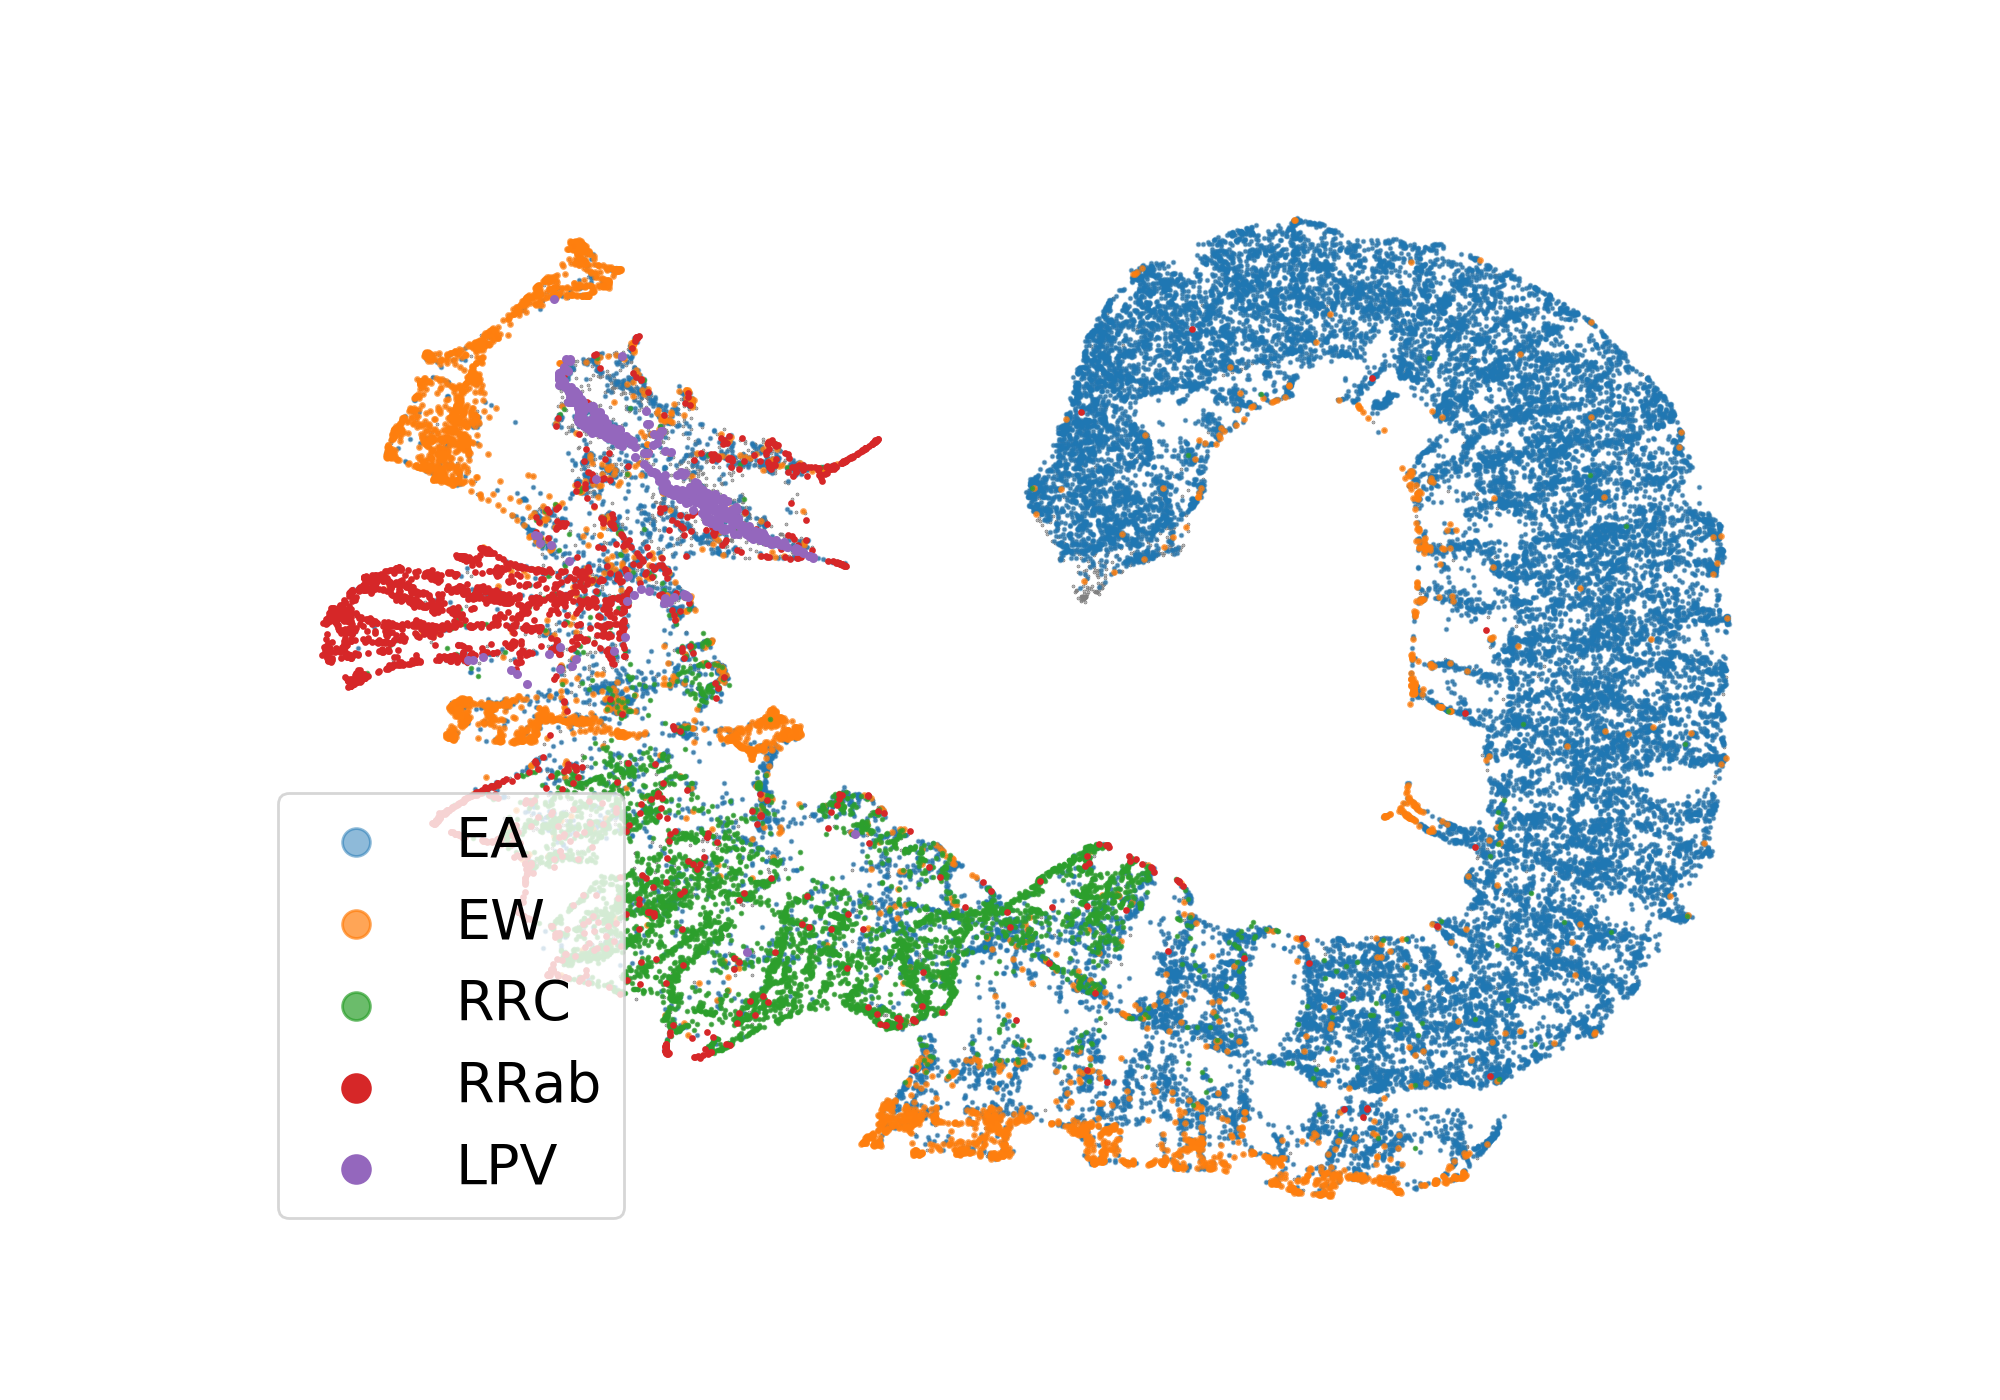

In [16]:
umap_results = numpy.load('umap_results_v6/umap_result_nn_50_md_0.25.npy')
y = numpy.load('lbls_all.npy')

xmap = umap_results[:, 0]
ymap = umap_results[:, 1]
plt.figure(figsize = (10,7))
#plt.title('nn={}, md={}'.format(nn, md))

plt.scatter(xmap, ymap, s=0.1, c='gray')

inds = numpy.where(y == 1)[0]
plt.scatter(xmap[inds], ymap[inds], s = 1, alpha = 0.5, label = 'EA')

inds = numpy.where(y == 2)[0]
plt.scatter(xmap[inds], ymap[inds], s = 2, alpha = 0.7, label = 'EW')

inds = numpy.where(y == 5)[0]
plt.scatter(xmap[inds], ymap[inds], s = 1, alpha = 0.7, label = 'RRC')

inds = numpy.where(y == 4)[0]
plt.scatter(xmap[inds], ymap[inds], s = 2, label = 'RRab')

inds = numpy.where(y == 13)[0]
plt.scatter(xmap[inds], ymap[inds], s = 5, label = 'LPV')



lgnd = plt.legend(fontsize = 20)
for lh in lgnd.legendHandles:
    lh.set_sizes([100])
#lgnd.legendHandles[0].set_sizes([100, 200])
#lgnd.legendHandles[1].set_sizes(10)

plt.axis('off')
#plt.xlim(get_plot_limit(x))
#plt.ylim(get_plot_limit(y))
plt.show()

# Nearest Neighbor classfication - UMAP, NN within a fixed radius

* Get the nearest neighbors

In [24]:
from sklearn.neighbors import NearestNeighbors

# Only use some of the labels - the ones that are in the dmdt paper
inds = numpy.where( (y == 1)  |  (y == 2) |  (y == 4)|  (y == 5)|  (y == 6)|  (y == 8)|  (y == 13))[0]
y_red = y[inds]


k1 = 100 
neighbors = NearestNeighbors(k1)
neighbors.fit(umap_results[inds])
nd, nn = neighbors.kneighbors(umap_results[inds], return_distance=True)
print('Example: the first 5 distances and NN for the first object')
nd[0,:5], nn[0,:5]

Example: the first 5 distances and NN for the first object


(array([0.  , 0.01, 0.02, 0.03, 0.03]),
 array([    0,  2826, 35075, 39779, 36509]))

* Classification

In [26]:
from collections import Counter
def nn_dists_classification_score(nn, dists, y, r=0.05):
    n_objects = len(y)
    true_count = 0
    pred = numpy.zeros(n_objects, dtype=int)
    for i in range(n_objects):
        nof_nn = numpy.argmax(nd[i] > r)
        if nof_nn < 2:
            nof_nn = 2
        c = Counter(y[nn[i,1:nof_nn]])
        pred_ = c.most_common(n=1)[0][0]
        if y[i] == pred_:
            true_count += 1
        pred[i] = pred_
    return float(true_count)/n_objects, pred

for r in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:
    score, pred =  nn_dists_classification_score(nn, nd, y_red, r= r)
    print('Radius: {}, score: {:.3}'.format(r, score))

Radius: 0.05, score: 0.815
Radius: 0.1, score: 0.836
Radius: 0.15, score: 0.845
Radius: 0.2, score: 0.848
Radius: 0.25, score: 0.849
Radius: 0.3, score: 0.847
Radius: 0.35, score: 0.843


## The best score for regular NN classification from the UMAP is 0.849:

In [31]:
score, pred =  nn_dists_classification_score(nn, nd, y_red, r= 0.25)
print('Radius: {:.2}, score: {:.3}'.format(r, score))

Radius: 0.35, score: 0.849


<IPython.core.display.Javascript object>


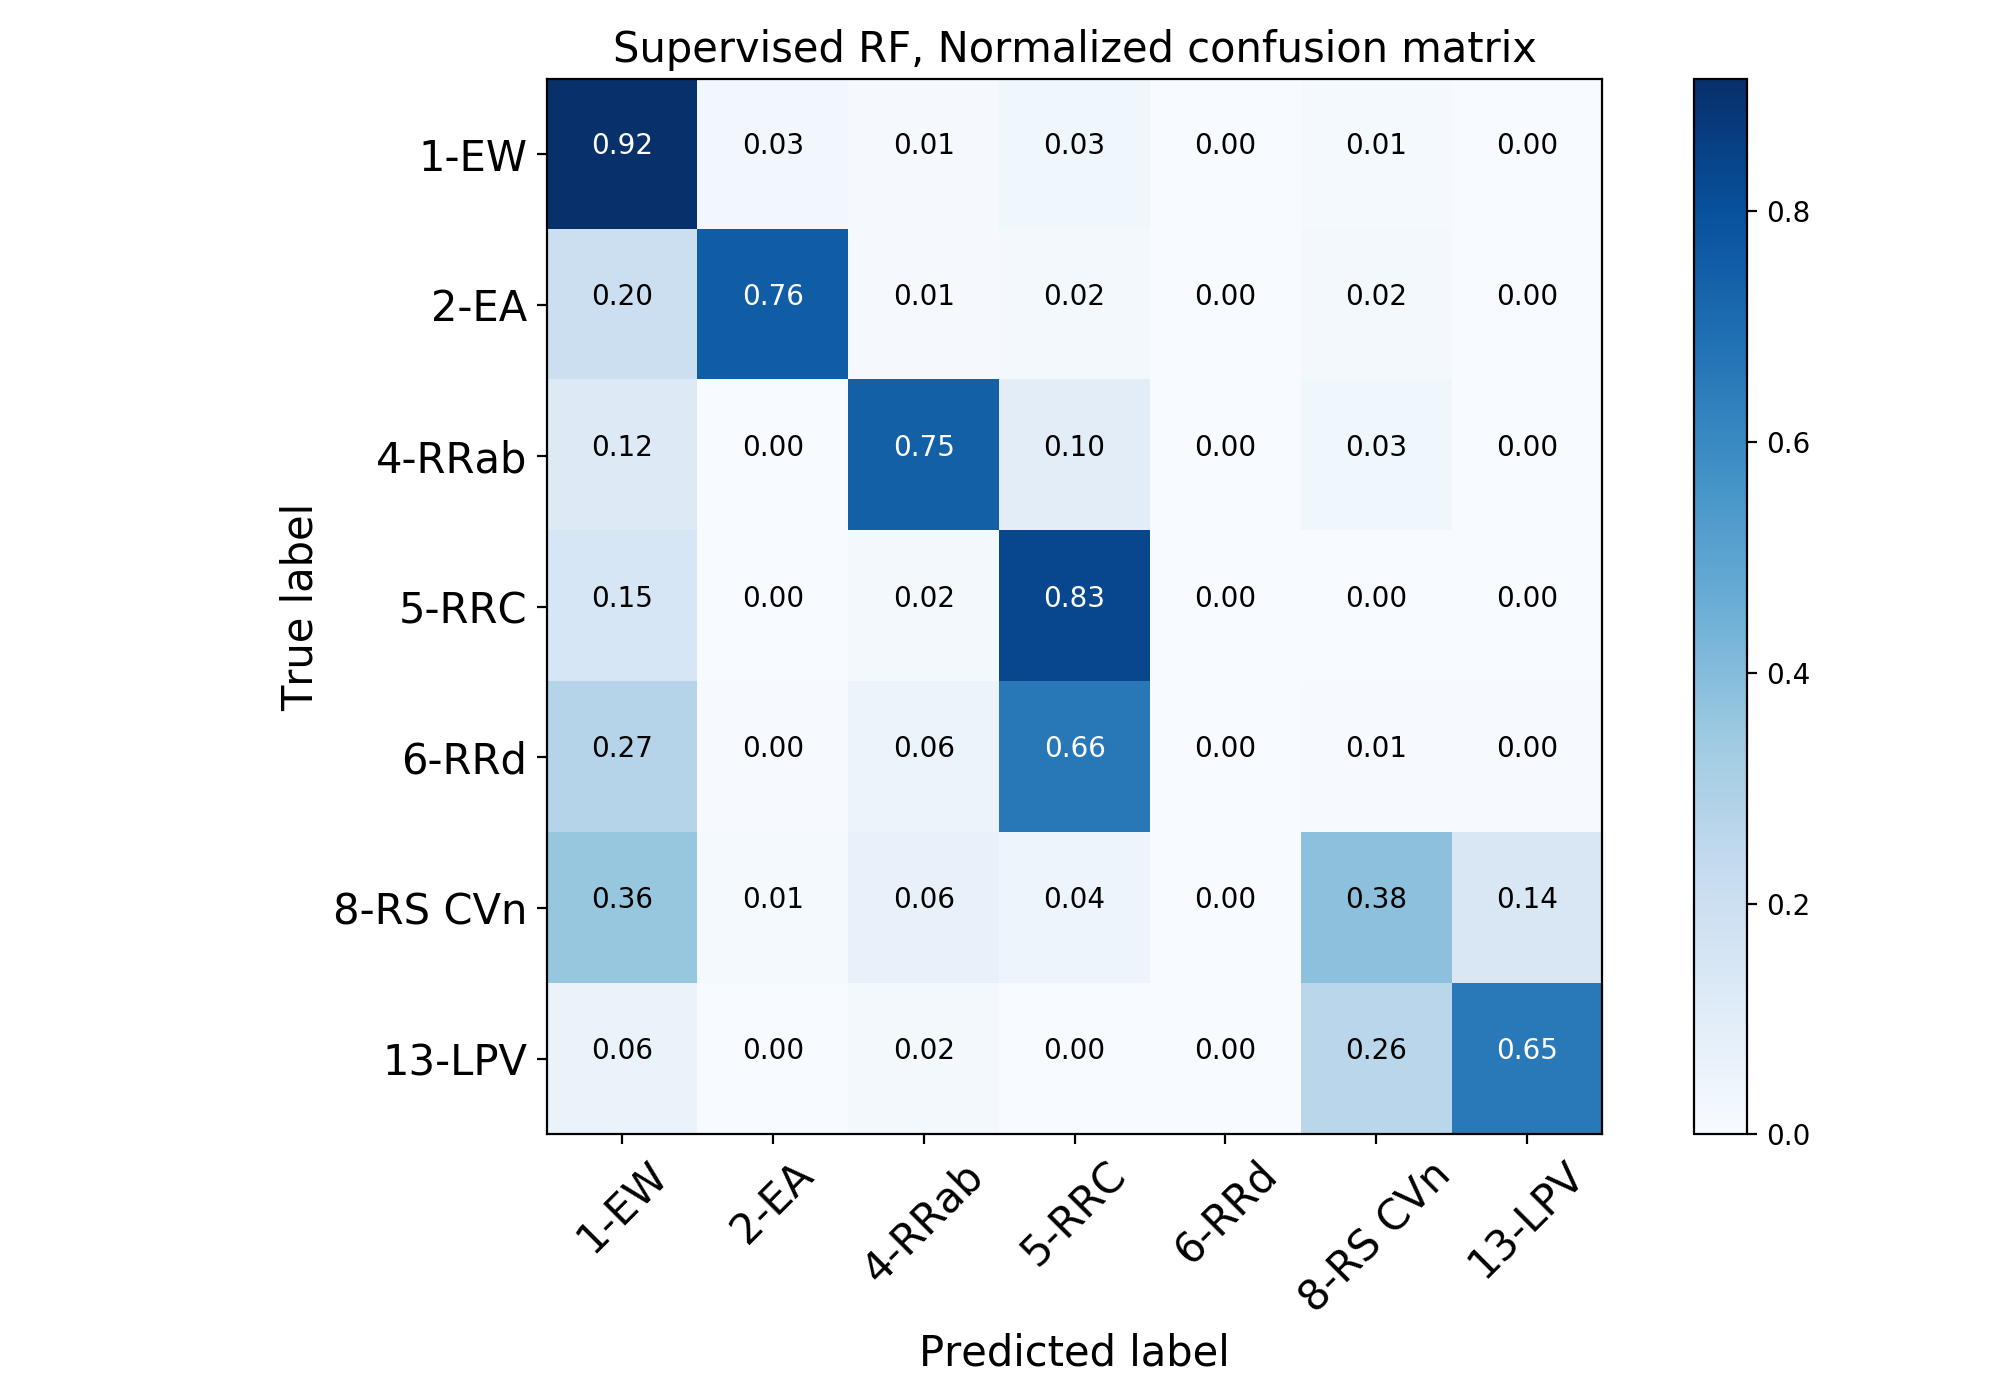

In [33]:
cnf_matrix = confusion_matrix(y_red, pred)

# Plot normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Supervised RF, Normalized confusion matrix')

plt.show()

# Putting a prior on the distribution on classes 

In [34]:
def predict_w_prior(nn, y, nof_nn = 10, f = 1):
    
    classes, nof_objects_per_class = numpy.unique(y, return_counts = True)
    
    nof_objects_per_class = (nof_objects_per_class*f).astype(int)
    n_objects = len(y)
    n_class = len(classes)
    class_counts_all = numpy.zeros([n_objects, n_class])
    for i in range(n_objects):

        for n in range(1,nof_nn):
            class_counts_all[i,classes == y[nn[i,n]]] += 1
            
            
            
    kinds_list = []
    tmp_label = numpy.ones(len(y_red))*(-1)
    for idx in range(n_class):
        nof_k = nof_objects_per_class[idx]

        kprobas_sort = numpy.sort(class_counts_all[:,idx])[::-1]
        kprobas_asort = numpy.argsort(class_counts_all[:,idx])[::-1]

        if kprobas_sort[nof_k-1] == 0:
            print('Warning: class', classes[idx], 'not enough non zero objects')
        kinds = kprobas_asort[:nof_k]
        tmp_label[kinds] = classes[idx]
        kinds_list += [kinds]
        
        
    nof_app = numpy.zeros(n_objects)

    objs, counts = numpy.unique(numpy.concatenate(kinds_list), return_counts = True)
    nof_app[objs] = counts
    pred = numpy.ones(n_objects)*(-1)
    for i in numpy.where(nof_app == 1)[0]:
        pred[i] = tmp_label[i]
    
    return pred

#pred = predict_w_prior(nn, y_red, nof_nn = 10)

In [36]:
for nnn in [5,10,15,25,50]:
    pred = predict_w_prior(nn, y_red, nof_nn = nnn)
    score = (y_red[pred > 0] == pred[pred > 0]).sum()/(pred > 0).sum()
    print('Nof NN: {}, score: {:.4}'.format(nnn, score))

Nof NN: 5, score: 0.8557
Nof NN: 10, score: 0.865
Nof NN: 15, score: 0.8672
Nof NN: 25, score: 0.8672
Nof NN: 50, score: 0.8666


## We can select ~0.5 fraction of the objects for which the classifier is must sure of, and get 0.92+ accuracy

In [38]:
for f in [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.25, 0.1][::-1]:
    pred = predict_w_prior(nn, y_red, nof_nn = 15, f=f)
    score = (y_red[pred > 0] == pred[pred > 0]).sum()/(pred > 0).sum()
    print('Selection fraction: {}, score: {:.4}, nof classified objects: {}'.format(f, score, (pred > 0).sum()))

Selection fraction: 0.1, score: 0.9439, nof classified objects: 4561
Selection fraction: 0.25, score: 0.9423, nof classified objects: 11406
Selection fraction: 0.5, score: 0.9278, nof classified objects: 22808
Selection fraction: 0.6, score: 0.9231, nof classified objects: 27347
Selection fraction: 0.7, score: 0.9185, nof classified objects: 31843
Selection fraction: 0.8, score: 0.9089, nof classified objects: 36308
Selection fraction: 0.9, score: 0.8869, nof classified objects: 40640
Selection fraction: 1, score: 0.8672, nof classified objects: 43092


In [41]:
pred = predict_w_prior(nn, y_red, nof_nn= 15, f=0.5)
score = (y_red[pred > 0] == pred[pred > 0]).sum()/(pred > 0).sum()
print('Selection fraction: {}, score: {:.4}, nof classified objects: {}'.format(f, score, (pred > 0).sum()))

Selection fraction: 1, score: 0.9278, nof classified objects: 22808


<IPython.core.display.Javascript object>


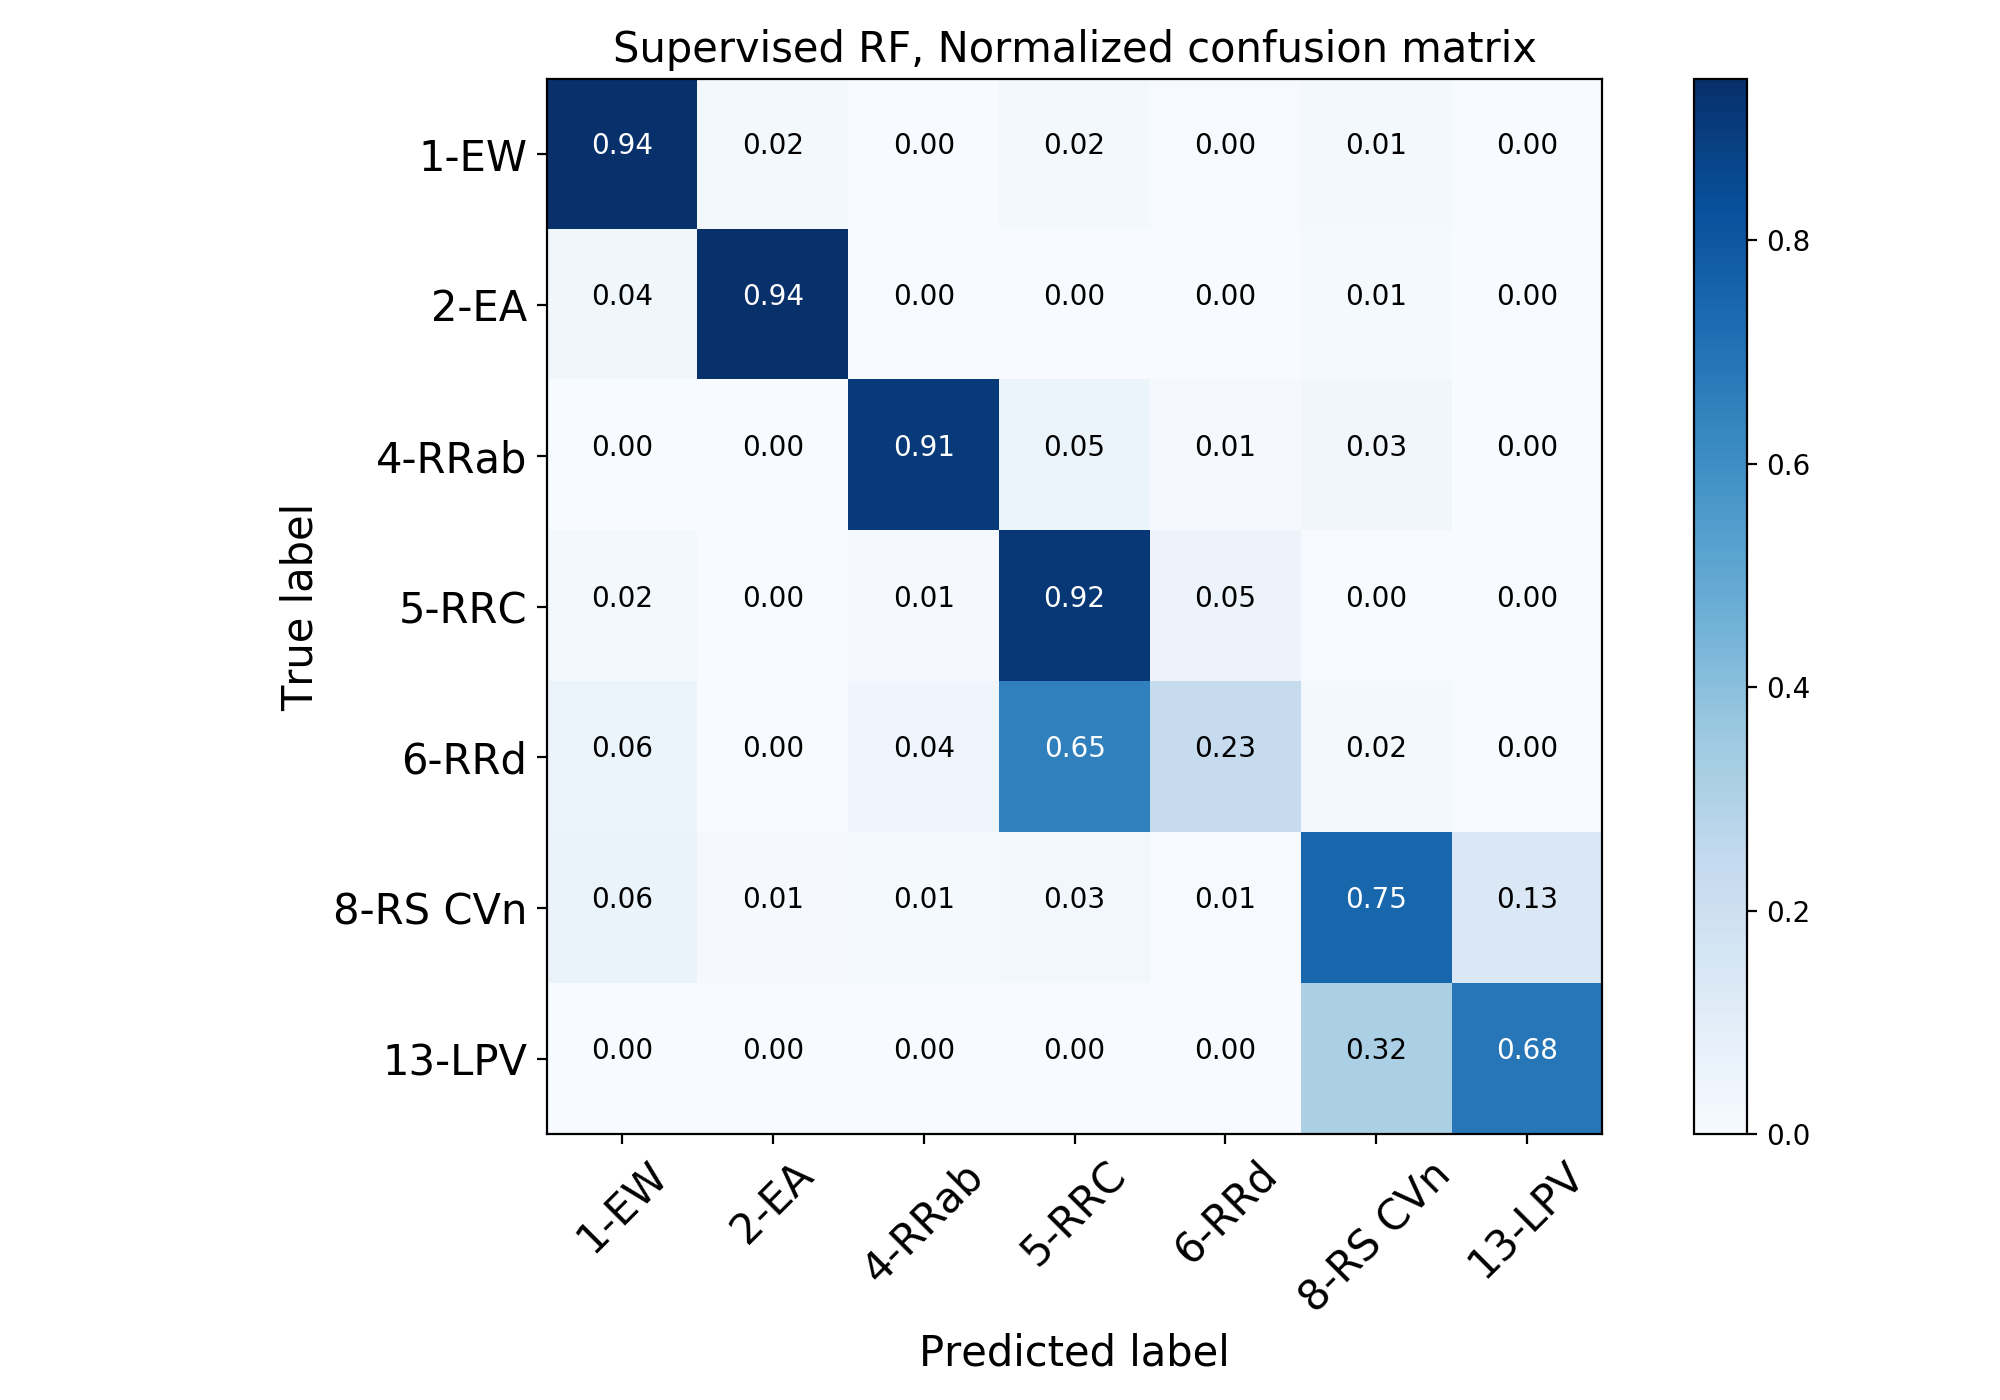

In [42]:
cnf_matrix = confusion_matrix(y_red[pred > 0], pred[pred > 0])

# Plot normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Supervised RF, Normalized confusion matrix')

plt.show()

# NN classification directly from the distances

In [44]:
X = numpy.load('X_supersmoother_both.npy')
#X = numpy.load('X_supersmoother_normed.npy')
y = numpy.load('lbls_all.npy')
#y[y > 2] = 2

n_objects = X.shape[0]
n_features = X.shape[1]
print(n_objects, 'objects,', n_features, 'features')

shuffled_inds = numpy.random.choice(numpy.arange(n_objects),n_objects,replace=False)

shuffled_inds = numpy.where( (y == 1)  |  (y == 2) |  (y == 4)|  (y == 5)|  (y == 6)|  (y == 8)|  (y == 13))[0]
shuffled_inds = numpy.random.choice(shuffled_inds,len(shuffled_inds),replace=False)
n_train = 20000
n_test = 20000
print('Train set size = {}, Test set size = {}'.format(n_train, n_test))

nf = n_features
train_inds = shuffled_inds[:n_train]
X_train = X[train_inds][:,:nf]
y_train = y[train_inds]

test_inds = shuffled_inds[n_train:(n_train + n_test)]
X_test = X[test_inds][:,:nf]
y_test = y[test_inds]

46821 objects, 2000 features
Train set size = 20000, Test set size = 20000


In [46]:
from sklearn.neighbors import KNeighborsClassifier
for k in [1,2,5,10,15,20,25,50]:
    neigh = KNeighborsClassifier(k, metric = 'correlation', weights='distance')
    neigh.fit(X_train, y_train, ) 
    pred = neigh.predict(X_test)
    score =  (pred == y_test).sum()/len(y_test)
    print('Nof NN: {}, score: {:.4}'.format(k, score))

Nof NN: 1, score: 0.8324
Nof NN: 2, score: 0.8324
Nof NN: 5, score: 0.8511
Nof NN: 10, score: 0.8546
Nof NN: 15, score: 0.8527
Nof NN: 20, score: 0.8505
Nof NN: 25, score: 0.8488
Nof NN: 50, score: 0.843


### Best score is 0.854, a bit better than uMAP distances

In [48]:
neigh = KNeighborsClassifier(10, metric = 'correlation', weights='distance')
neigh.fit(X_train, y_train, ) 
pred = neigh.predict(X_test)
score =  (pred == y_test).sum()/len(y_test)
print('Nof NN: {}, score: {:.4}'.format(k, score))

Nof NN: 50, score: 0.8546


<IPython.core.display.Javascript object>


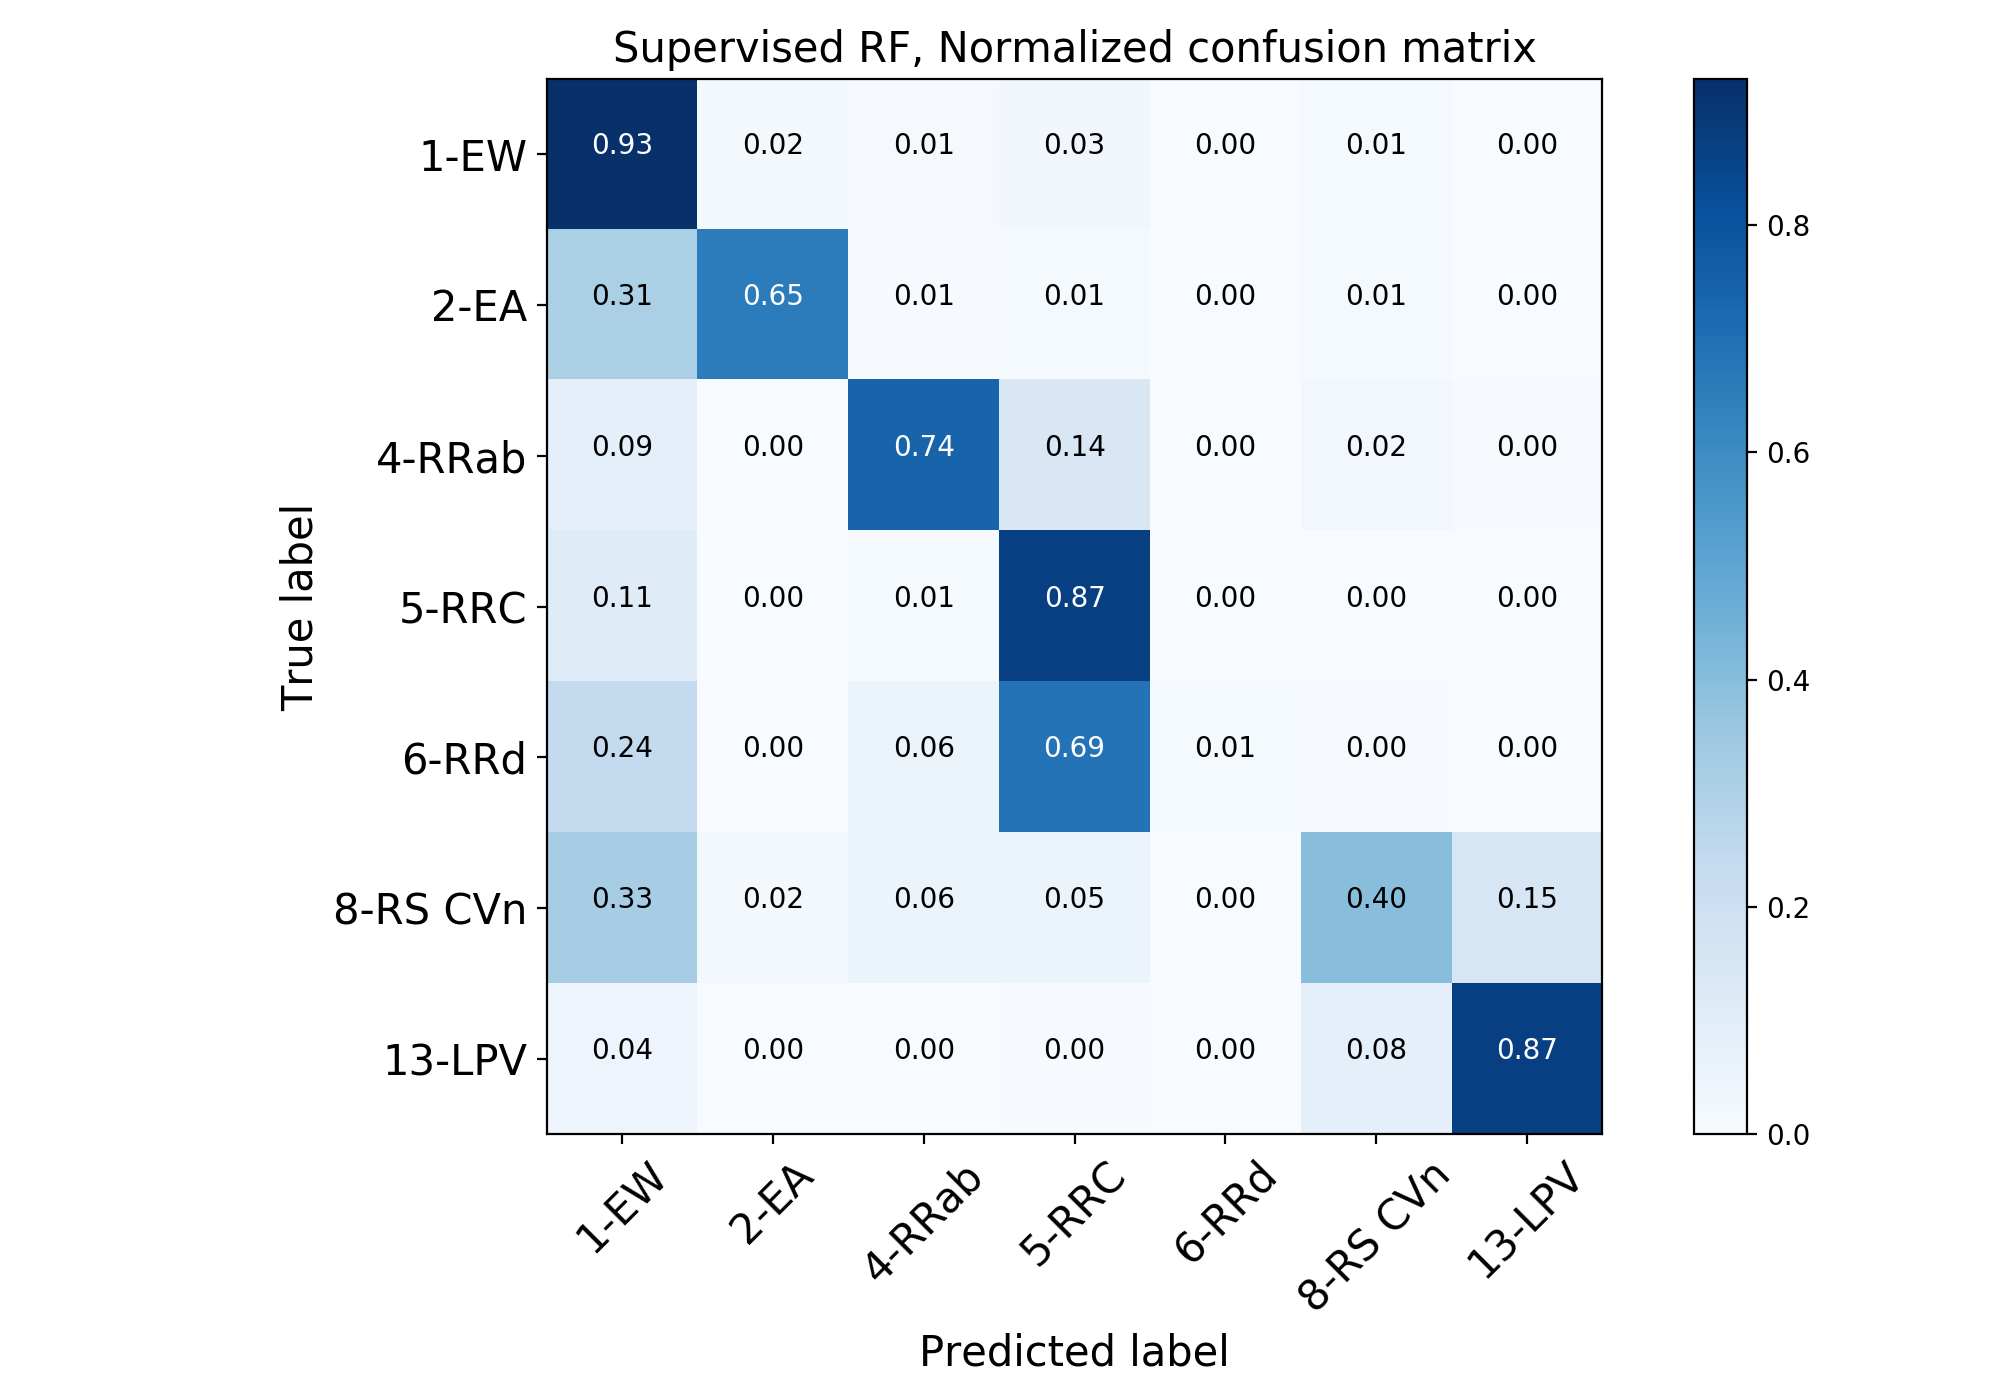

In [49]:
cnf_matrix = confusion_matrix(y_test, pred)

# Plot normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Supervised RF, Normalized confusion matrix')

plt.show()

## Now with a prior

In [47]:
from sklearn.neighbors import NearestNeighbors

# Only use some of the labels - the ones that are in the dmdt paper
inds = numpy.where( (y == 1)  |  (y == 2) |  (y == 4)|  (y == 5)|  (y == 6)|  (y == 8)|  (y == 13))[0]
y_red = y[inds]


k1 = 100 
neighbors = NearestNeighbors(k1, metric='correlation')
neighbors.fit(X[inds])
nd, nn = neighbors.kneighbors(X[inds], return_distance=True)
print('Example: the first 5 distances and NN for the first object')
nd[0,:5], nn[0,:5]

Example: the first 5 distances and NN for the first object


(array([-2.22e-16,  5.00e-03,  5.56e-03,  6.64e-03,  6.83e-03]),
 array([    0,  5045, 28680, 36509, 29271]))

In [50]:
for nnn in [5,10,15,25,50]:
    pred = predict_w_prior(nn, y_red, nof_nn = nnn)
    score = (y_red[pred > 0] == pred[pred > 0]).sum()/(pred > 0).sum()
    print('Nof NN: {}, score: {:.4}'.format(nnn, score))

Nof NN: 5, score: 0.8752
Nof NN: 10, score: 0.8825
Nof NN: 15, score: 0.8851
Nof NN: 25, score: 0.8853
Nof NN: 50, score: 0.8827


## These are better results than taking the umap distances. We can select ~0.5 fraction of the objects for which the classifier is must sure of, and get 0.94+ accuracy

In [51]:
for f in [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.25, 0.1][::-1]:
    pred = predict_w_prior(nn, y_red, nof_nn = 15, f=f)
    score = (y_red[pred > 0] == pred[pred > 0]).sum()/(pred > 0).sum()
    print('Selection fraction: {}, score: {:.4}, nof classified objects: {}'.format(f, score, (pred > 0).sum()))

Selection fraction: 0.1, score: 0.9572, nof classified objects: 4561
Selection fraction: 0.25, score: 0.9547, nof classified objects: 11406
Selection fraction: 0.5, score: 0.9427, nof classified objects: 22814
Selection fraction: 0.6, score: 0.937, nof classified objects: 27375
Selection fraction: 0.7, score: 0.9308, nof classified objects: 31935
Selection fraction: 0.8, score: 0.9208, nof classified objects: 36460
Selection fraction: 0.9, score: 0.8996, nof classified objects: 40854
Selection fraction: 1, score: 0.8851, nof classified objects: 42660


In [52]:
pred = predict_w_prior(nn, y_red, nof_nn= 15, f=0.5)
score = (y_red[pred > 0] == pred[pred > 0]).sum()/(pred > 0).sum()
print('Selection fraction: {}, score: {:.4}, nof classified objects: {}'.format(f, score, (pred > 0).sum()))

Selection fraction: 1, score: 0.9427, nof classified objects: 22814


<IPython.core.display.Javascript object>


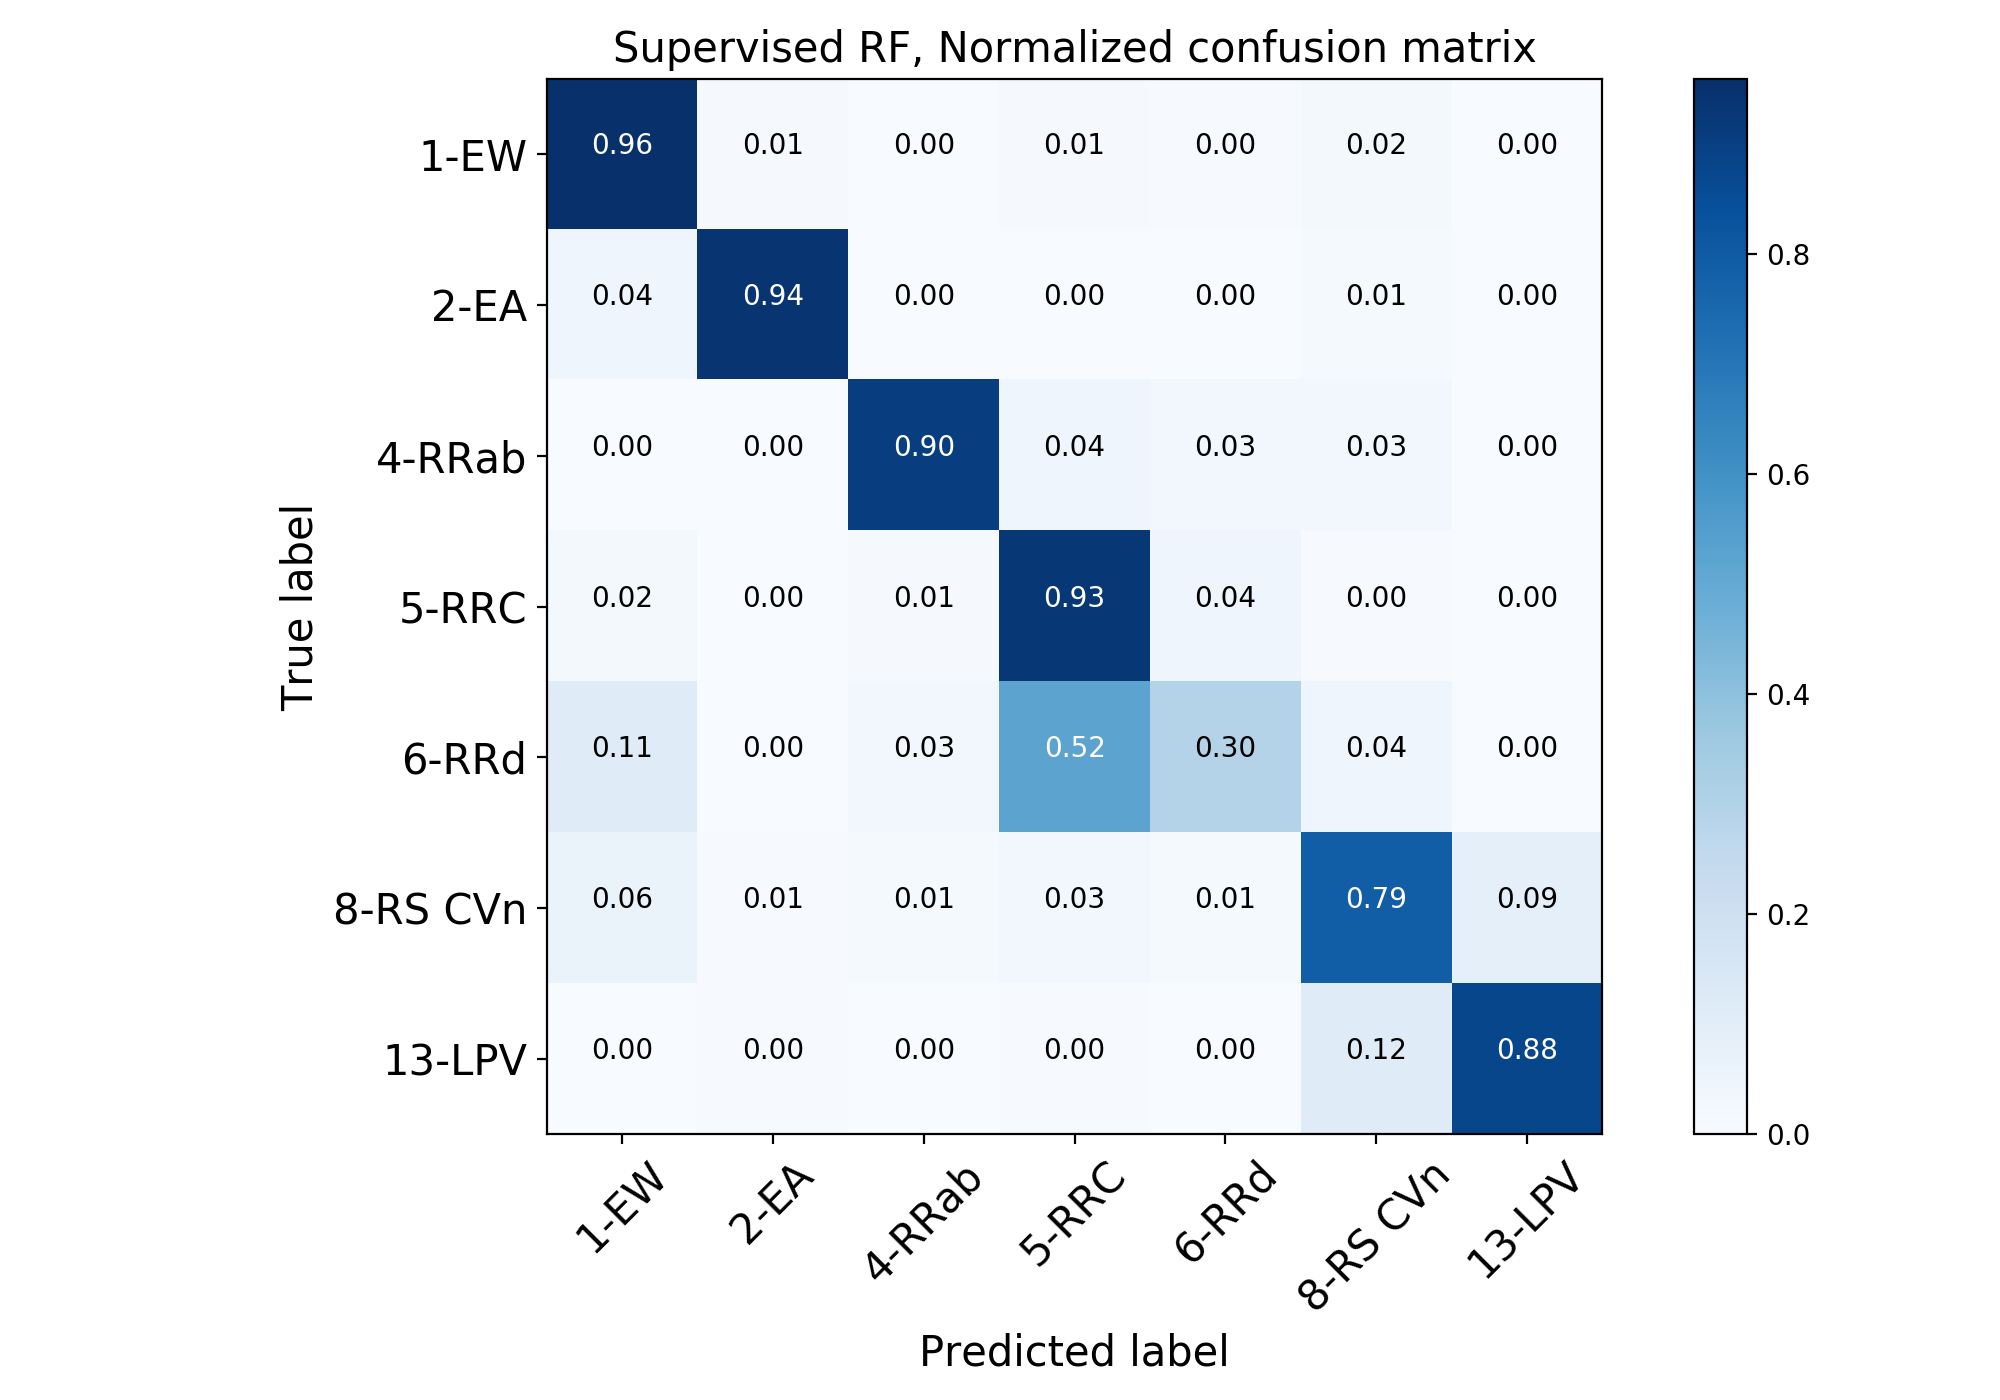

In [53]:
cnf_matrix = confusion_matrix(y_red[pred > 0], pred[pred > 0])

# Plot normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Supervised RF, Normalized confusion matrix')

plt.show()